<a href="https://colab.research.google.com/github/russmendez/DS_Thinkful_Mendez/blob/master/Supervised_Learning_on_Credit_Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
from pandas import DataFrame
from sklearn.model_selection import train_test_split,  cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn import svm

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge


from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.dummy import DummyClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, fbeta_score
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

import warnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('drive/My Drive/archive.zip')

Mounted at /content/drive


The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [ ]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
data.isna().sum()*100/data.count()

Time      0.0
V1        0.0
V2        0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V14       0.0
V15       0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
Amount    0.0
Class     0.0
dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


284315
492
0.17304750013189596


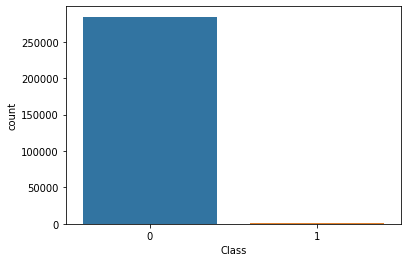

In [ ]:
#Confirm the imbalance in the target
sns.countplot(data['Class'])
print(len(data[data['Class'] == 0]))
print(len(data[data['Class'] == 1]))
print((len(data[data['Class'] == 1]))/(len(data[data['Class'] == 0]))*100)

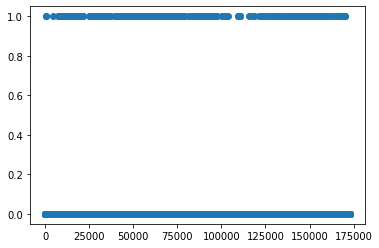

In [ ]:
#This is not a great visual but it helps to show that the fraudulent charges take place over the entire timespan
plt.scatter(data.Time, data.Class)

Text(0, 0.5, 'Fraudulent Transactions')

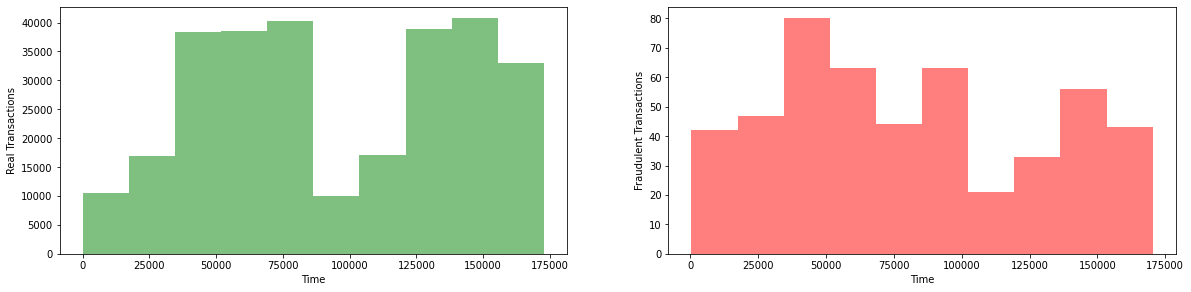

In [ ]:
#Check to ensure the fraudulent charges happen over the entire timespan
class_0 = data.loc[data['Class'] == 0]["Time"]
class_1 = data.loc[data['Class'] == 1]["Time"]

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.hist(class_0, color='green', alpha=.5)
plt.xlabel('Time')
plt.ylabel('Real Transactions')
plt.subplot(2,2,2)
plt.hist(class_1, color='red', alpha=.5)
plt.xlabel('Time')
plt.ylabel('Fraudulent Transactions')

#Both types of transactions take place over the whole time interval. Fraudulent charges show a more equal distibution over time.
#There is a dip in real transations while fraudulent transations stays relatively high. 

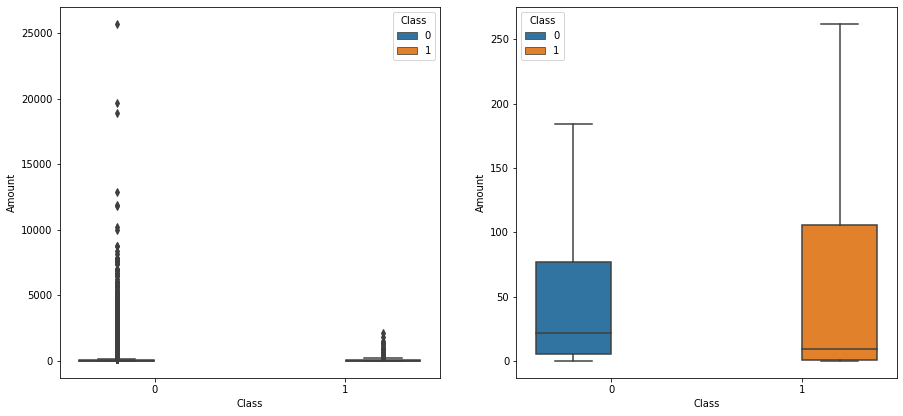

In [ ]:

plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
sns.boxplot(x="Class", y="Amount", hue="Class",data=data)
plt.subplot(2,2,2)
sns.boxplot(x="Class", y="Amount", hue="Class",data=data, showfliers=False)
plt.show()

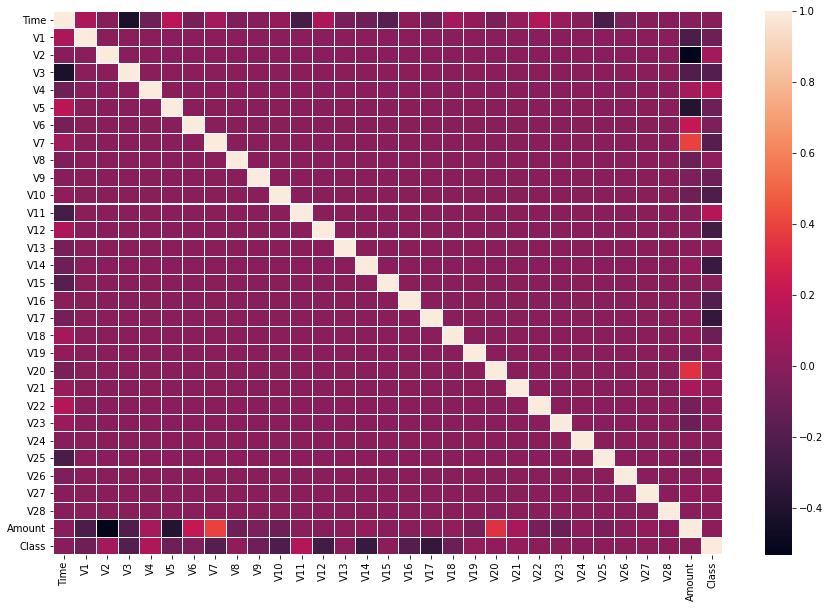

In [ ]:
plt.figure(figsize=(15,10))
corr = data.corr()
sns.heatmap(corr, linewidths=.1)
plt.show()
#V7 and V20 visually appeaer to have the highest correlation to another feature, Amount. But they apear to be about .4 and should be fine to use. 

#Functions

In [ ]:
#probs = lr.predict_proba(X_test)[:, 1]
#pres, rec, thresholds = precision_recall_curve(y_test, lr_predictions)
#Change model abbreviation
def pr_roc(var):

  plt.figure()
  fig = plt.figure(figsize= (18,6))

  plt.subplot(1,3,1)

  fpr, tpr, thresholds = roc_curve(y_test, probs)
  #fig = plt.figure(figsize = (6, 6))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  #plt.show()

  plt.subplot(1,3,2)

  #fig = plt.figure(figsize = (6, 6))
  plt.plot(rec, pres)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  #plt.show()

  plt.subplot(1,3,3)
  #fig = plt.figure(figsize = (6, 6))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr)
  plt.fill(fpr, tpr, 'grey', alpha=0.3)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  #plt.show()
  auc = roc_auc_score(y_test, probs)
  print('Area under the ROC curve: {:.3f}'.format(auc))

#Models

We are looking to recude as many instances of false negatives, that is, missing an instance of fraudulent charge. The extent to which we want to limit false positives depends on the banks responce to a false positive. If the bank simply sends a notification to the user to confirm, then false positives are not much of a concern. If the bank locks the card bases on false positives false positives are highly problematic. 

In [ ]:
target_df = data['Class']
feature_df = data.drop(columns='Class')

In [ ]:
y = pd.DataFrame(data['Class'])
X = data.drop(columns='Class')
X_train, X_test, y_train, y_test = train_test_split(X,y)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(213605, 30)
(213605, 1)
(71202, 30)
(71202, 1)


###LogisticRegression

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score on training data:  0.9991760492497834
Score on test data:  0.9992415943372377
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71083
           1       0.82      0.71      0.76       119

    accuracy                           1.00     71202
   macro avg       0.91      0.85      0.88     71202
weighted avg       1.00      1.00      1.00     71202

Fbeta score favoring precision: 0.79
FBeta score favoring recall: 0.73
roc_auc_score:0.8528075298884238


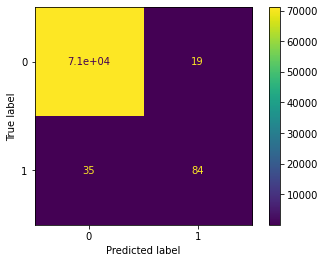

In [ ]:
#not balanced
lr = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=2)
results =lr.fit(X_train, y_train)

lr_score = lr.score(X_test, y_test)
lr_predictions = lr.predict(X_test)

train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)
print(classification_report(y_test, lr_predictions))
#To favor precision, a value of  𝛽<1  is used, and to favor recall, a value of  𝛽>1  is used
fbeta_precision = fbeta_score(y_test, lr_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, lr_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))
print(f'roc_auc_score:{roc_auc_score(y_test, lr_predictions)}')
#print(f'cross_val_score: {cross_val_score(lr, X, y, cv=10)}')
plot_confusion_matrix(lr, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score on training data:  0.9662133377027692
Score on test data:  0.9657172551332828
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     71083
           1       0.04      0.92      0.08       119

    accuracy                           0.97     71202
   macro avg       0.52      0.95      0.53     71202
weighted avg       1.00      0.97      0.98     71202

Fbeta score favoring precision: 0.05
FBeta score favoring recall: 0.18
roc_auc_score:0.9450781114325224


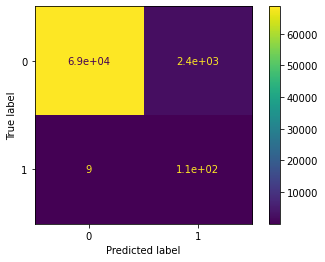

In [ ]:
#balanced
balanced_lr = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=2, )
results =balanced_lr.fit(X_train, y_train)

balanced_lr_score = lr.score(X_test, y_test)
balanced_lr_predictions = lr.predict(X_test)

train_score = balanced_lr.score(X_train, y_train)
test_score = balanced_lr.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)
print(classification_report(y_test, balanced_lr_predictions))
#To favor precision, a value of  𝛽<1  is used, and to favor recall, a value of  𝛽>1  is used
fbeta_precision = fbeta_score(y_test, lr_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, balanced_lr_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))
print(f'roc_auc_score:{roc_auc_score(y_test, balanced_lr_predictions)}')
#print(f'cross_val_score: {cross_val_score(lr, X, y, cv=10)}')
plot_confusion_matrix(balanced_lr, X_test, y_test)

The LogisticRegression model with class_wheight='balanced' misses the least false negatives of all the models. It also has the most amount of false positives. 

###Decision Tree

Score on training data:  1.0
Score on test data:  0.9992135052386169
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71074
           1       0.80      0.75      0.77       128

    accuracy                           1.00     71202
   macro avg       0.90      0.87      0.89     71202
weighted avg       1.00      1.00      1.00     71202

Fbeta score favoring precision: 0.79
FBeta score favoring recall: 0.76
roc_auc_score:0.8748311618876101


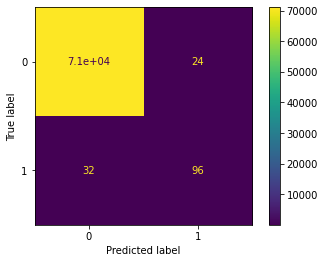

In [ ]:
dt = DecisionTreeClassifier(random_state=2)


dt.fit(X_train,y_train)

dt_score = dt.score(X_test, y_test)
dt_predictions = dt.predict(X_test)

train_score = dt.score(X_train, y_train)
test_score = dt.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

print(classification_report(y_test, dt_predictions))

fbeta_precision = fbeta_score(y_test, dt_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, dt_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))
print(f'roc_auc_score:{roc_auc_score(y_test, dt_predictions)}')
plot_confusion_matrix(dt, X_test, y_test)

Score on training data:  0.9997378338522038
Score on test data:  0.9994943962248252
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71074
           1       0.93      0.77      0.85       128

    accuracy                           1.00     71202
   macro avg       0.97      0.89      0.92     71202
weighted avg       1.00      1.00      1.00     71202

Fbeta score favoring precision: 0.90
FBeta score favoring recall: 0.80
roc_auc_score:0.886669505550553


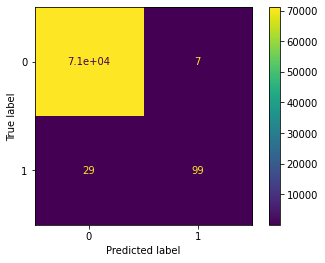

In [ ]:
dt = DecisionTreeClassifier(max_depth=10, random_state=2)

dt.fit(X_train,y_train)

dt_score = dt.score(X_test, y_test)
dt_predictions = dt.predict(X_test)

train_score = dt.score(X_train, y_train)
test_score = dt.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

print(classification_report(y_test, dt_predictions))

fbeta_precision = fbeta_score(y_test, dt_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, dt_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))
print(f'roc_auc_score:{roc_auc_score(y_test, dt_predictions)}')
plot_confusion_matrix(dt, X_test, y_test)

Score on training data:  1.0
Score on test data:  0.999283727985169
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71074
           1       0.81      0.79      0.80       128

    accuracy                           1.00     71202
   macro avg       0.90      0.89      0.90     71202
weighted avg       1.00      1.00      1.00     71202

Fbeta score favoring precision: 0.80
FBeta score favoring recall: 0.79
roc_auc_score:0.8943624118876101


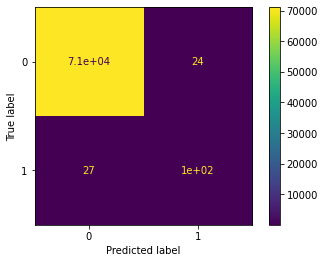

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=2)

dt.fit(X_train,y_train)

dt_score = dt.score(X_test, y_test)
dt_predictions = dt.predict(X_test)

train_score = dt.score(X_train, y_train)
test_score = dt.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

print(classification_report(y_test, dt_predictions))

fbeta_precision = fbeta_score(y_test, dt_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, dt_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))
print(f'roc_auc_score:{roc_auc_score(y_test, dt_predictions)}')
plot_confusion_matrix(dt, X_test, y_test)

Score on training data:  0.9997378338522038
Score on test data:  0.9994943962248252
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71074
           1       0.93      0.77      0.85       128

    accuracy                           1.00     71202
   macro avg       0.97      0.89      0.92     71202
weighted avg       1.00      1.00      1.00     71202

Fbeta score favoring precision: 0.90
FBeta score favoring recall: 0.80
roc_auc_score:0.886669505550553


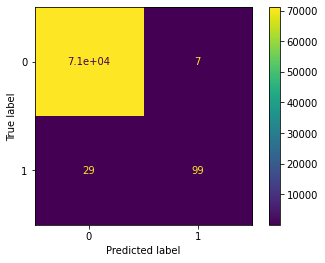

In [ ]:
dt = DecisionTreeClassifier(random_state=2, class_weight='balanced')

dt = DecisionTreeClassifier(max_depth=10, random_state=2)

dt.fit(X_train,y_train)

dt_score = dt.score(X_test, y_test)
dt_predictions = dt.predict(X_test)

train_score = dt.score(X_train, y_train)
test_score = dt.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

print(classification_report(y_test, dt_predictions))

fbeta_precision = fbeta_score(y_test, dt_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, dt_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))
print(f'roc_auc_score:{roc_auc_score(y_test, dt_predictions)}')
plot_confusion_matrix(dt, X_test, y_test)

Score on training data:  0.9997565600056179
Score on test data:  0.9994382180275835
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71083
           1       0.92      0.73      0.81       119

    accuracy                           1.00     71202
   macro avg       0.96      0.87      0.91     71202
weighted avg       1.00      1.00      1.00     71202

Fbeta score favoring precision: 0.87
FBeta score favoring recall: 0.76
roc_auc_score:0.865489946242273


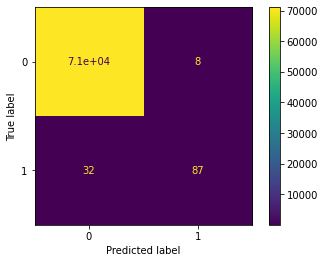

In [ ]:
dt = DecisionTreeClassifier(random_state=2, class_weight='balanced', criterion='entropy')

dt = DecisionTreeClassifier(max_depth=10, random_state=2)

dt.fit(X_train,y_train)

dt_score = dt.score(X_test, y_test)
dt_predictions = dt.predict(X_test)

train_score = dt.score(X_train, y_train)
test_score = dt.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

print(classification_report(y_test, dt_predictions))

fbeta_precision = fbeta_score(y_test, dt_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, dt_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))
print(f'roc_auc_score:{roc_auc_score(y_test, dt_predictions)}')
plot_confusion_matrix(dt, X_test, y_test)

The DicisionTree with criterion='entropy' performed the best, however, it still underperformed the LogisticRegression model

###RandomForest

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Score on training data:  0.9999765923082324
Score on test data:  0.9995505744220669
[[71069     5]
 [   27   101]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71074
           1       0.95      0.79      0.86       128

    accuracy                           1.00     71202
   macro avg       0.98      0.89      0.93     71202
weighted avg       1.00      1.00      1.00     71202

Fbeta score favoring precision: 0.91
FBeta score favoring recall: 0.82
roc_auc_score:0.894496075393252


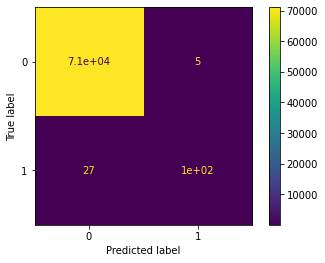

In [ ]:
rf = RandomForestClassifier(n_estimators = 22, random_state = 40)

rf.fit(X_train,y_train)

rf_score = rf.score(X_test, y_test)
rf_predictions = rf.predict(X_test)

train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)
print(confusion_matrix(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

fbeta_precision = fbeta_score(y_test, rf_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, rf_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))
print(f'roc_auc_score:{roc_auc_score(y_test, rf_predictions)}')
plot_confusion_matrix(rf, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Score on training data:  0.999971910769879
Score on test data:  0.9995084407741356
[[71068     6]
 [   29    99]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71074
           1       0.94      0.77      0.85       128

    accuracy                           1.00     71202
   macro avg       0.97      0.89      0.92     71202
weighted avg       1.00      1.00      1.00     71202

Fbeta score favoring precision: 0.90
FBeta score favoring recall: 0.80
roc_auc_score:0.8866765404719026


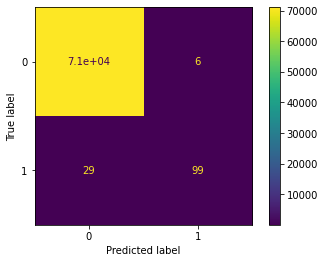

In [ ]:
rf = RandomForestClassifier(n_estimators = 22, random_state = 40, class_weight='balanced')

rf.fit(X_train,y_train)

rf_score = rf.score(X_test, y_test)
rf_predictions = rf.predict(X_test)

train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)
print(confusion_matrix(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

fbeta_precision = fbeta_score(y_test, rf_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, rf_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))
print(f'roc_auc_score:{roc_auc_score(y_test, rf_predictions)}')
plot_confusion_matrix(rf, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Score on training data:  1.0
Score on test data:  0.9995786635206876
[[71070     4]
 [   26   102]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71074
           1       0.96      0.80      0.87       128

    accuracy                           1.00     71202
   macro avg       0.98      0.90      0.94     71202
weighted avg       1.00      1.00      1.00     71202

Fbeta score favoring precision: 0.92
FBeta score favoring recall: 0.83
roc_auc_score:0.8984093603146016


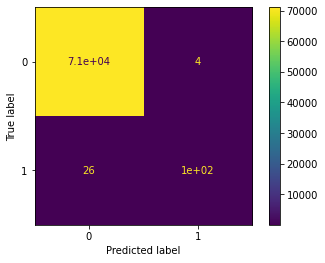

In [ ]:
rf = RandomForestClassifier(random_state = 40)

rf.fit(X_train,y_train)

rf_score = rf.score(X_test, y_test)
rf_predictions = rf.predict(X_test)

train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)
print(confusion_matrix(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

fbeta_precision = fbeta_score(y_test, rf_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, rf_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))
print(f'roc_auc_score:{roc_auc_score(y_test, rf_predictions)}')
plot_confusion_matrix(rf, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Score on training data:  1.0
Score on test data:  0.9995786635206876
[[71070     4]
 [   26   102]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71074
           1       0.96      0.80      0.87       128

    accuracy                           1.00     71202
   macro avg       0.98      0.90      0.94     71202
weighted avg       1.00      1.00      1.00     71202

Fbeta score favoring precision: 0.92
FBeta score favoring recall: 0.83
roc_auc_score:0.8984093603146016


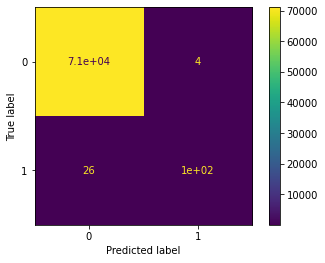

In [ ]:
rf = RandomForestClassifier(random_state = 40, bootstrap=True)

rf.fit(X_train,y_train)

rf_score = rf.score(X_test, y_test)
rf_predictions = rf.predict(X_test)

train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)
print(confusion_matrix(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

fbeta_precision = fbeta_score(y_test, rf_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, rf_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))
print(f'roc_auc_score:{roc_auc_score(y_test, rf_predictions)}')
plot_confusion_matrix(rf, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Score on training data:  0.9999953184616465
Score on test data:  0.9995365298727564
[[71080     3]
 [   30    89]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71083
           1       0.97      0.75      0.84       119

    accuracy                           1.00     71202
   macro avg       0.98      0.87      0.92     71202
weighted avg       1.00      1.00      1.00     71202

Fbeta score favoring precision: 0.91
FBeta score favoring recall: 0.78
roc_auc_score:0.8739284777400121


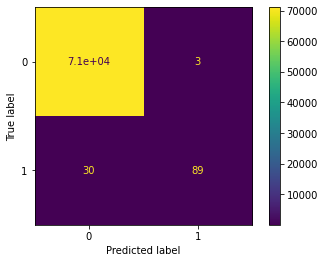

In [ ]:
rf = RandomForestClassifier(random_state = 40,class_weight='balanced', bootstrap=True)

rf.fit(X_train,y_train)

rf_score = rf.score(X_test, y_test)
rf_predictions = rf.predict(X_test)

train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)
print(confusion_matrix(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

fbeta_precision = fbeta_score(y_test, rf_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, rf_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))
print(f'roc_auc_score:{roc_auc_score(y_test, rf_predictions)}')
plot_confusion_matrix(rf, X_test, y_test)

No version of the RandomForest did better than a single DecidionTree. 

KNearestNeighbbor

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


Score on training data:  0.998389550806395
Score on test data:  0.9982865649841297
[[71074     0]
 [  122     6]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71074
           1       1.00      0.05      0.09       128

    accuracy                           1.00     71202
   macro avg       1.00      0.52      0.54     71202
weighted avg       1.00      1.00      1.00     71202

Fbeta score favoring precision: 0.20
FBeta score favoring recall: 0.06
roc_auc_score:0.5234375


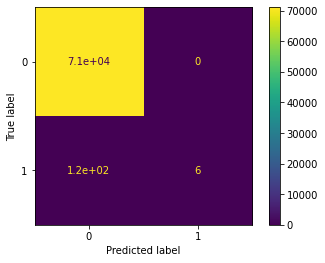

In [ ]:
knn = KNeighborsClassifier(n_neighbors=7)

# Then  fit the model
knn.fit(X_train, y_train)

# How well did we do
knn_7_score = knn.score(X_test, y_test)
knn_7_predictions = knn.predict(X_test)

train_score = knn.score(X_train, y_train)
test_score = knn.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)
print(confusion_matrix(y_test, knn_7_predictions))
print(classification_report(y_test, knn_7_predictions))

fbeta_precision = fbeta_score(y_test, knn_7_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, knn_7_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))
print(f'roc_auc_score:{roc_auc_score(y_test, knn_7_predictions)}')
plot_confusion_matrix(knn, X_test, y_test)

KNearestNeighbor was not expect to perform well as the data is highly unbalanced.

###SVM

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Score on training data:  0.5889422064090261
Score on test data:  0.5871323839217999
              precision    recall  f1-score   support

           0       1.00      0.59      0.74     71074
           1       0.00      0.33      0.00       128

    accuracy                           0.59     71202
   macro avg       0.50      0.46      0.37     71202
weighted avg       1.00      0.59      0.74     71202

Fbeta score favoring precision: 0.00
FBeta score favoring recall: 0.01
roc_auc_score:0.4578619203224808


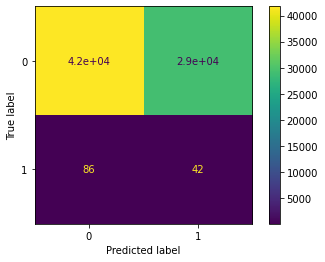

In [ ]:
#The misclassification or error term tells the SVM optimization how much error is bearable. 
#This is how you can control the trade-off between decision boundary and misclassification term. 
#A smaller value of C creates a small-margin hyperplane and a larger value of C creates a larger-margin hyperplane.

#Gamma: A lower value of Gamma will loosely fit the training dataset, whereas a higher value of gamma will exactly fit the training dataset, which causes over-fitting. 

clf = svm.SVC(max_iter = 500, kernel='linear')
clf.fit(X_train, y_train)
clf_score = clf.score(X_test, y_test)
clf_predictions = clf.predict(X_test)

train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)
print(classification_report(y_test, clf_predictions))

fbeta_precision = fbeta_score(y_test, clf_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, clf_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))
print(f'roc_auc_score:{roc_auc_score(y_test, clf_predictions)}')
plot_confusion_matrix(clf, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Score on training data:  0.9982959200393249
Score on test data:  0.9982022976882672
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71074
           1       0.00      0.00      0.00       128

    accuracy                           1.00     71202
   macro avg       0.50      0.50      0.50     71202
weighted avg       1.00      1.00      1.00     71202

Fbeta score favoring precision: 0.00
FBeta score favoring recall: 0.00
roc_auc_score:0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


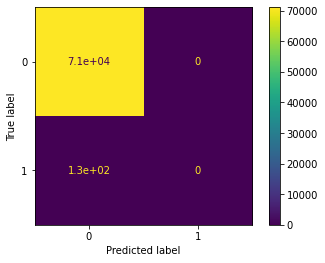

In [ ]:
clf = svm.SVC(max_iter = 500, kernel='poly')
clf.fit(X_train, y_train)
clf_score = clf.score(X_test, y_test)
clf_predictions = clf.predict(X_test)

train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)
print(classification_report(y_test, clf_predictions))

fbeta_precision = fbeta_score(y_test, clf_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, clf_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))
print(f'roc_auc_score:{roc_auc_score(y_test, clf_predictions)}')
plot_confusion_matrix(clf, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score on training data:  0.9982959200393249
Score on test data:  0.9982022976882672
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71074
           1       0.00      0.00      0.00       128

    accuracy                           1.00     71202
   macro avg       0.50      0.50      0.50     71202
weighted avg       1.00      1.00      1.00     71202

Fbeta score favoring precision: 0.00
FBeta score favoring recall: 0.00
roc_auc_score:0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


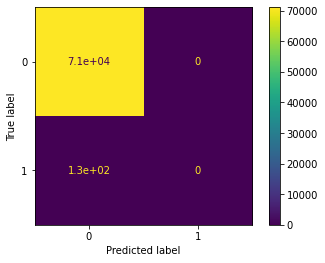

In [ ]:
clf = svm.SVC(max_iter=500, kernel='rbf')
clf.fit(X_train, y_train)
clf_score = clf.score(X_test, y_test)
clf_predictions = clf.predict(X_test)

train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)
print(classification_report(y_test, clf_predictions))

fbeta_precision = fbeta_score(y_test, clf_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, clf_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))
print(f'roc_auc_score:{roc_auc_score(y_test, clf_predictions)}')
plot_confusion_matrix(clf, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Score on training data:  0.5889422064090261
Score on test data:  0.5871323839217999
              precision    recall  f1-score   support

           0       1.00      0.59      0.74     71074
           1       0.00      0.33      0.00       128

    accuracy                           0.59     71202
   macro avg       0.50      0.46      0.37     71202
weighted avg       1.00      0.59      0.74     71202

Fbeta score favoring precision: 0.00
FBeta score favoring recall: 0.01
roc_auc_score:0.4578619203224808


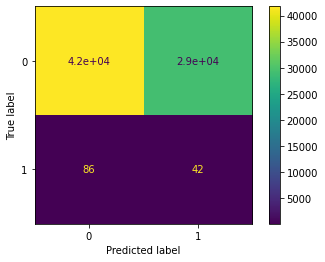

In [ ]:
#The misclassification or error term tells the SVM optimization how much error is bearable. 
#This is how you can control the trade-off between decision boundary and misclassification term. 
#A smaller value of C creates a small-margin hyperplane and a larger value of C creates a larger-margin hyperplane.

#Gamma: A lower value of Gamma will loosely fit the training dataset, whereas a higher value of gamma will exactly fit the training dataset, which causes over-fitting. 

clf = svm.SVC(max_iter = 500, kernel='linear', C=10)
clf.fit(X_train, y_train)
clf_score = clf.score(X_test, y_test)
clf_predictions = clf.predict(X_test)

train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)
print(classification_report(y_test, clf_predictions))

fbeta_precision = fbeta_score(y_test, clf_predictions, 0.5)
fbeta_recall = fbeta_score(y_test, clf_predictions, 2)
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))
print(f'roc_auc_score:{roc_auc_score(y_test, clf_predictions)}')
plot_confusion_matrix(clf, X_test, y_test)

No version of the SVC was able to perform well.

#Conclusion

The LogisticRegression with class_wheight='balanced' model performed the best. There is a possible problem with the number of false positives predicted. 